In [1]:
#Librerias - Codigo desarrollado a partir de la implementación de Tensorflow - https://www.tensorflow.org/tutorials/generative/cyclegan?hl=es-419
import tensorflow as tf
import os 
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.layers import InstanceNormalization

from keras.preprocessing.image import random_rotation,random_shift


#Directorio con los distintos datasets para el entrenamiento
dir_young = 'dataset2/young/male/noglasses/'
dir_adults = 'dataset2/adult/male/glasses/'
dir_test_young = 'C:/stylegan/new_data/young/female/noglasses/'
dir_test_adult = 'C:/stylegan/new_data/adult/female/noglasses/'


#Función que carga las imágenes
def load_image(filename):
  image = tf.io.read_file(filename)
  
  image = tf.image.decode_png(image, channels=3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)

  image = tf.image.resize(image, [140, 140])
  return image


In [2]:
#Configuración de memoria
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
orig_img_size = (286, 286)
# Tamaño de la imagen, para entrenamiento y para realizar los cortes para el aumento de datos.
input_img_size = (128, 128, 3)

buffer_size = 32
batch_size = 1

autotune = tf.data.AUTOTUNE

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img * 2) - 1.0


#Función que prepocesa y aplica el aumento de datos a la imagen de entrenamiento
def preprocess_train_image(img):
    # Flip aleatorio
    img = tf.image.random_flip_left_right(img)
    #Recorte aleatorio
    img = tf.image.random_crop(img, size=[*input_img_size])

    img = normalize_img(img)
    return img

#Función que prepocesa las imagenes de test
def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:

train_young = tf.data.Dataset.list_files(dir_young + '*png' , shuffle=True)
train_adult = tf.data.Dataset.list_files(dir_adults + '*png', shuffle=True)

test_young = tf.data.Dataset.list_files(dir_test_young + '*png', shuffle=True)
test_adult = tf.data.Dataset.list_files(dir_test_adult + '*png', shuffle=True)

train_young = train_young.map(load_image)
train_adult = train_adult.map(load_image)

test_young = test_young.map(load_image)
test_adult = test_adult.map(load_image)

train_young = (
train_young.map(preprocess_train_image, num_parallel_calls=autotune)
    .shuffle(buffer_size)
    .batch(batch_size)
)

train_adult = (
    train_adult.map(preprocess_train_image, num_parallel_calls=autotune)
    .shuffle(buffer_size)
    .batch(batch_size)
)

test_young = (
    test_young.map(preprocess_test_image, num_parallel_calls=autotune)
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_adult = (
    test_adult.map(preprocess_test_image, num_parallel_calls=autotune)
    .shuffle(buffer_size)
    .batch(batch_size)
)



In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_young.take(4), train_adult.take(4))):
    young = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    adult = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(young)
    ax[i, 1].imshow(adult)
plt.show()


In [5]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def residual_block(input,activation,kernel_initializer=kernel_init,kernel_size=(3, 3),strides=(1, 1),padding="same",gamma_initializer=gamma_init,use_bias=False,):
    dim = input.shape[-1]

    x = layers.Conv2D(dim,kernel_size,strides=strides,kernel_initializer=kernel_initializer,padding=padding,use_bias=use_bias,)(input)
    # x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = layers.Conv2D(dim,kernel_size,strides=strides,kernel_initializer=kernel_initializer,padding=padding,use_bias=use_bias,)(x)
    # x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([x, input])
    return x


def downsample(input,filters,activation,kernel_initializer=kernel_init, kernel_size=(3, 3),strides=(2, 2), padding="same", instancenorm = True,gamma_initializer=gamma_init, use_bias=False):
    x = layers.Conv2D(filters,kernel_size,strides=strides,
        kernel_initializer=kernel_initializer, padding=padding,use_bias=use_bias)(input)
    
    if instancenorm:
        x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)

    x = activation(x)
    return x


def upsample(x,filters,activation,kernel_size=(3, 3),strides=(2, 2),padding="same",kernel_initializer=kernel_init,instancenorm = True,gamma_initializer=gamma_init,use_bias=False,):
    x = layers.Conv2DTranspose(filters,kernel_size,strides=strides,padding=padding,kernel_initializer=kernel_initializer,use_bias=use_bias,)(x)
    
    if instancenorm:
        x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    
    x = activation(x)
    return x


In [6]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=3,
    num_residual_blocks=9,
    num_upsample_blocks=3,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    
    x1 = downsample(img_input,64,kernel_size=(7,7),strides=(1,1),activation=layers.LeakyReLU(0.2),instancenorm=False)
    x2 = downsample(x1,128,activation=layers.LeakyReLU(0.2))
    x3 = downsample(x2,256,activation=layers.LeakyReLU(0.2))
    x4 = downsample(x3,512,activation=layers.LeakyReLU(0.2))

    x = x4
    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.LeakyReLU(0.2))

    
    # x_skip = layers.Concatenate(name="skip1")([x,x4])
    x = upsample(x,256,activation=layers.LeakyReLU(0.2))
    # x_skip = layers.Concatenate(name="skip2")([u1,x3])
    x = upsample(x,128,activation=layers.LeakyReLU(0.2))
    # x_skip = layers.Concatenate(name="skip3")([u2,x2])
    x = upsample(x,64,activation=layers.LeakyReLU(0.2))
    # x_skip = layers.Concatenate(name="skip4")([u3,x1])

    # Final block
    # x = ReflectionPadding2D(padding=(3, 3))(x)
    output = layers.Conv2D(3, (7, 7), padding="same",use_bias=False,activation='tanh')(x)

    model = keras.models.Model(img_input, output, name=name)
    return model


In [7]:
model = get_resnet_generator(name="Prueba")
model.summary()

c:\Users\delce\.conda\envs\cyclegan\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "Prueba"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Prueba_img_input (InputLayer)  [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9408        ['Prueba_img_input[0][0]']       
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                            

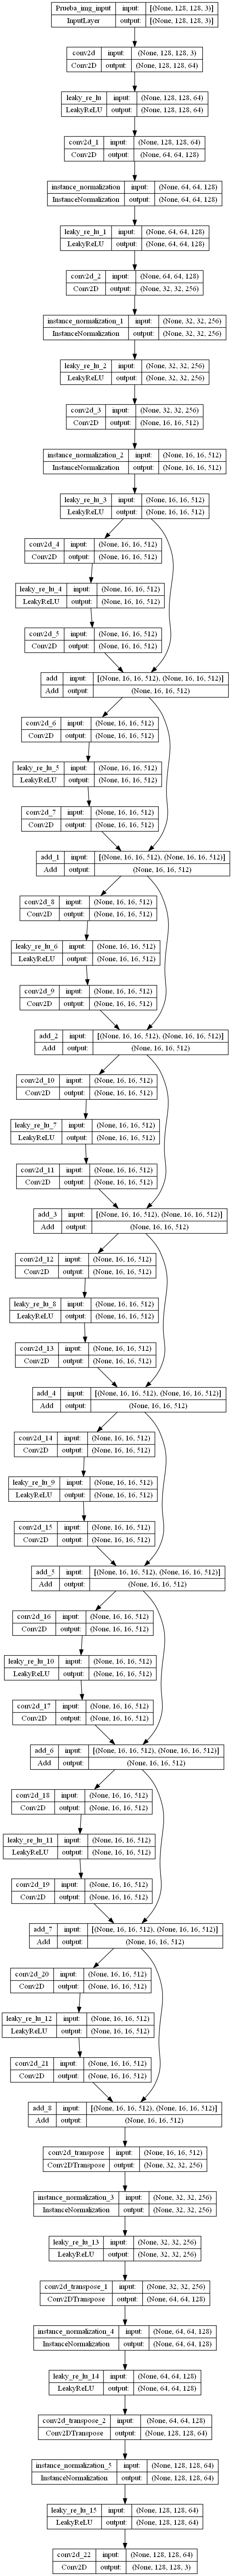

In [8]:
tf.keras.utils.plot_model(model, to_file='prueba.png', show_shapes=True)


In [7]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters,(4, 4),strides=(2, 2), padding="same", kernel_initializer=kernel_initializer,)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x,filters=num_filters,activation=layers.LeakyReLU(0.2),kernel_size=(4, 4),strides=(2, 2),)
        else:
            x = downsample( x,filters=num_filters,activation=layers.LeakyReLU(0.2),kernel_size=(4, 4),strides=(1, 1),)

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="valid", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


c:\ProgramData\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [8]:
class CycleGan(keras.Model):
    def __init__( self,generator_G,generator_F,discriminator_X,discriminator_Y,lambda_cycle=10.0,lambda_identity=0.5,):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile( self,gen_G_optimizer,gen_F_optimizer,disc_X_optimizer,disc_Y_optimizer, gen_loss_fn, disc_loss_fn,):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [9]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_adult.take(self.num_img)):
            prediction = self.model.gen_F(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


In [10]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model.save_weights('cycle')
# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)




In [ ]:
print(tf.config.list_physical_devices())

In [11]:
cycle_gan_model.load_weights('models/glassesMale/checkpoint900')

In [11]:
cycle_gan_model.load_weights('cycleSegPrueba2Final')

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
for i in range(500):
    cycle_gan_model.fit(
        tf.data.Dataset.zip((train_young, train_adult)),
        epochs=1,
        callbacks=[plotter],
    )
    
    if i % 50 == 0:
        cycle_gan_model.save_weights('models/glassesMale/checkpoint' + str(i+550))

In [ ]:
aux_cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)
aux_cycle_gan_model.load_weights('cycleV29')


In [11]:
cycle_gan_model.load_weights('cycleSegFemale580')

In [22]:
cycle_gan_model.load_weights('cycleSegPrueba749')

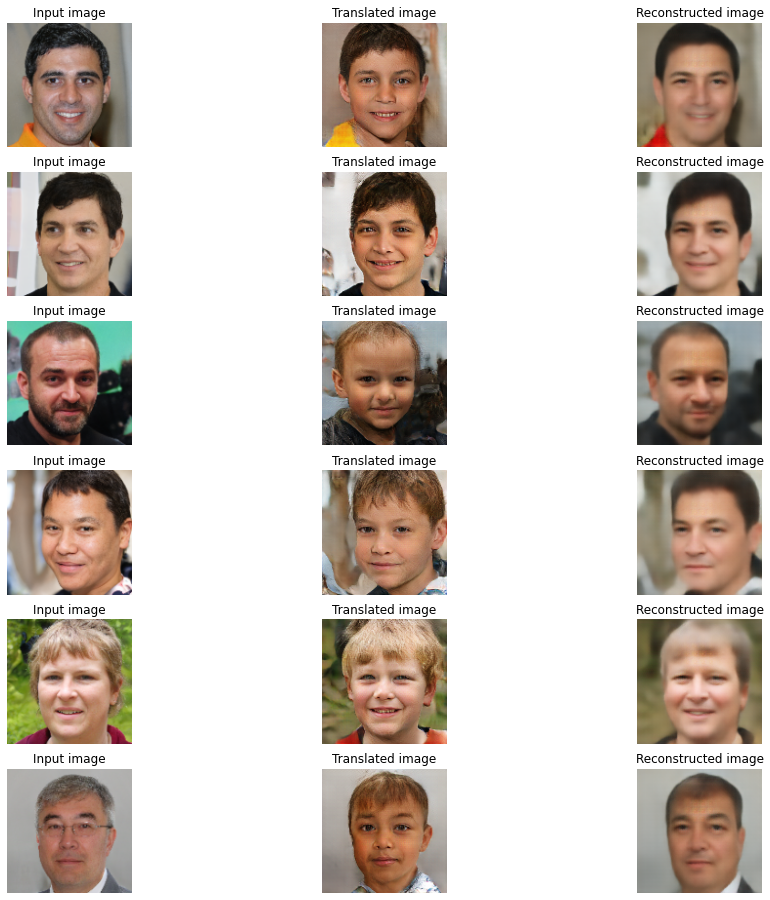

In [48]:
_, ax = plt.subplots(6, 3, figsize=(16, 16))
for i, img in enumerate(test_adult.take(6)):
    pred = cycle_gan_model.gen_F(img)
    prediction = cycle_gan_model.gen_F(img)[0].numpy()
    recons = cycle_gan_model.gen_G(pred)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    recons = (recons * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(recons)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 2].set_title("Reconstructed image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()
plt.close()

In [17]:
import cv2
i = 1
for img in test_adult:
    prediction = cycle_gan_model.gen_F(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    cv2.imwrite('fidGen/femNoGl/seed' + str(i) + '.png',cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR))
    i = i + 1 
    

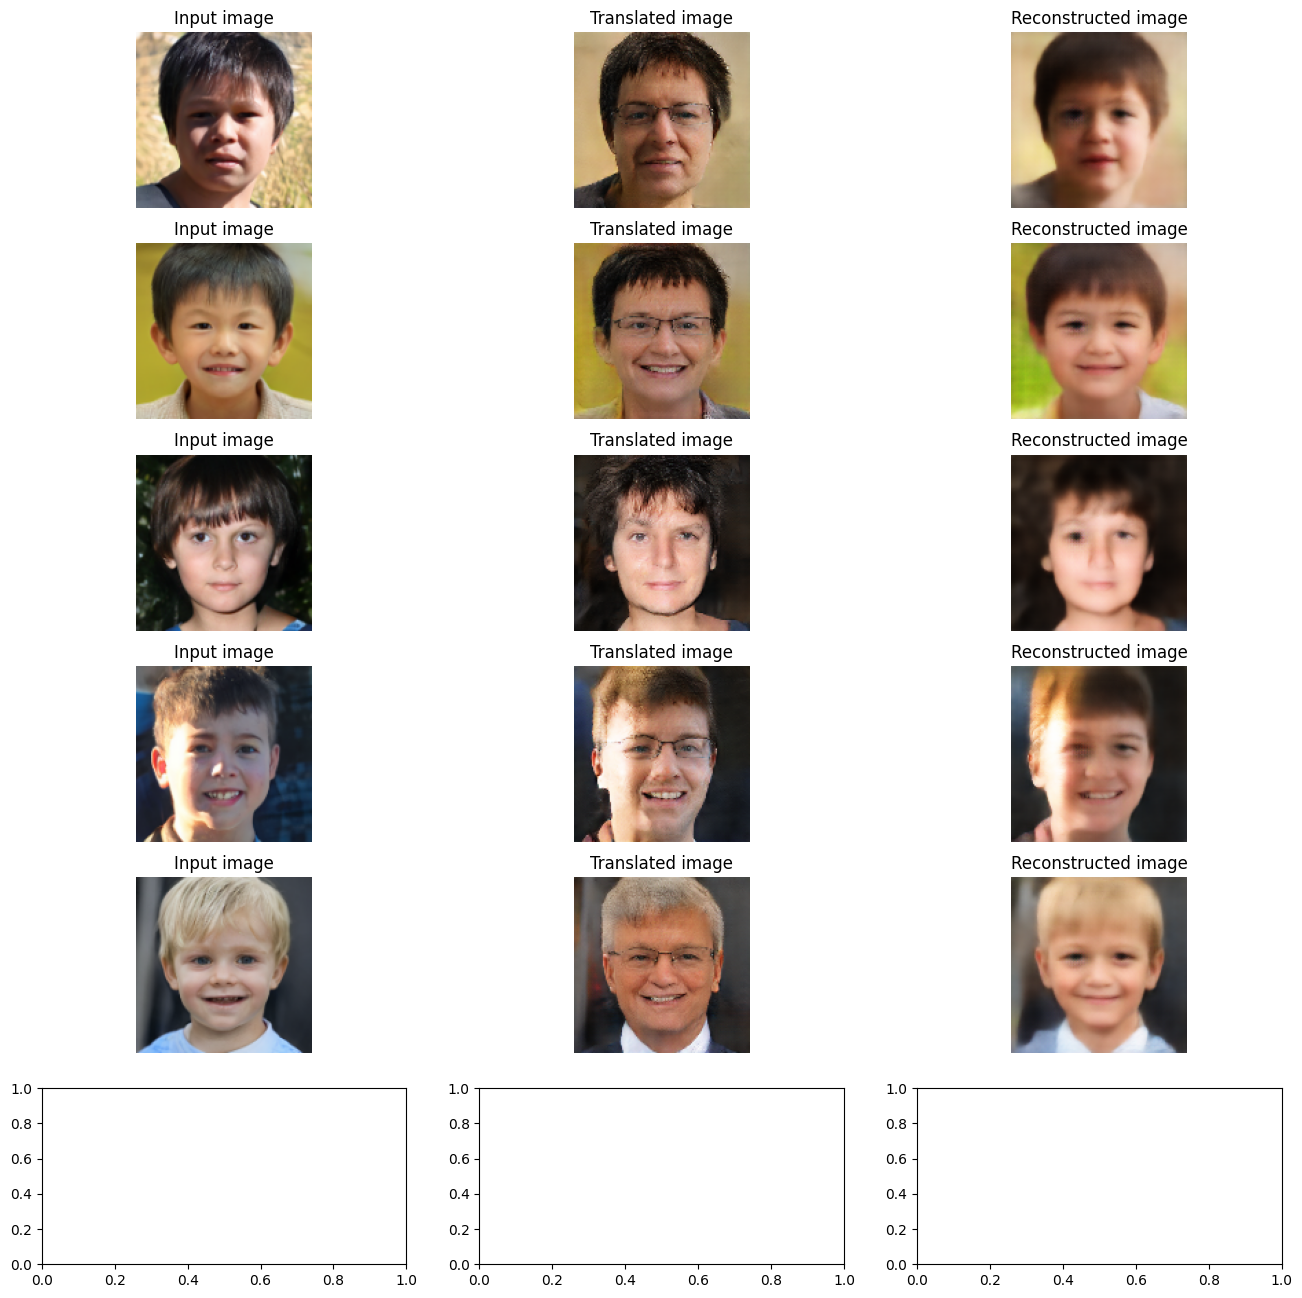

In [15]:
_, ax = plt.subplots(6, 3, figsize=(16, 16))
for i, img in enumerate(test_young.take(6)):
    pred = cycle_gan_model.gen_G(img)
    prediction = cycle_gan_model.gen_G(img)[0].numpy()
    recons = cycle_gan_model.gen_F(pred)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    recons = (recons * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(recons)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 2].set_title("Reconstructed image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()
plt.close()